## Load data

In [1]:
import numpy as np
import _pickle as pkl
import torch
from torchvision import transforms
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import os, sys, time
sys.path.append('..')
from utils import (set_seed_torch, Normalize)
set_seed_torch(3)

In [15]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
args = ObjectView({'res': 64,
 'dataset_path': '/media/m2-drive/datasets/pendulum-srl-sim/{}'
                   .format("pendulum64_total_2048_traj_16_repeat_2_with_angle_train.pkl"),
 'models_path': '/home/olimoyo/latent-metric-control/saved_models/{}'
                   .format("test_models"),
 'device': 'cuda:0',
 'n_examples': 2,
 'n_predictions': 11,
})

In [3]:
with open(args.dataset_path, 'rb') as f:
    data = pkl.load(f)
    
imgs_cached, actions, gt_state = data[0], data[1], data[2]
imgs_cached = imgs_cached.reshape(imgs_cached.shape[0], imgs_cached.shape[1], args.res, args.res, 3)
imgs = torch.empty((imgs_cached.shape[0], imgs_cached.shape[1], 1, 
                    imgs_cached.shape[2], imgs_cached.shape[3]), device=args.device)
actions = torch.from_numpy(actions).to(device=args.device)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    Normalize(mean=0.27, var=1.0 - 0.27) # 64x64
    ])
        
for ii in range(imgs_cached.shape[0]):
    for jj in range(imgs_cached.shape[1]):
        imgs[ii, jj, :, :, :] = transform(imgs_cached[ii, jj, :, :, :])

## Visualize

In [9]:
from utils import load_models
from argparse import Namespace
import json
import torch.nn as nn

Loading models in path:  /home/olimoyo/latent-metric-control/saved_models/test_models/05-12-20_16:25:35_untrained
torch.Size([2, 12, 3])
x_hat (2, 12, 2, 64, 64)
x (2, 13, 1, 64, 64)


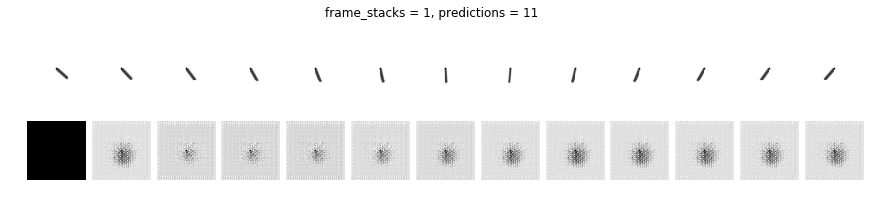

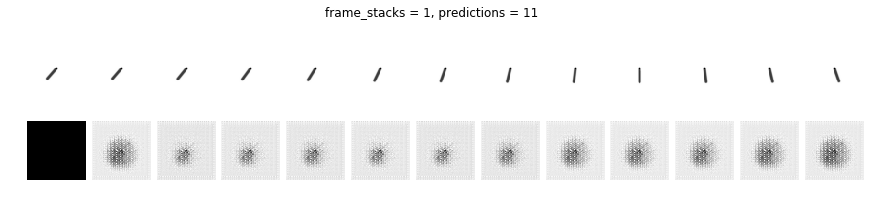

In [22]:
paths_list = []
args_list = []

# Load hyperparameters from trained model
for filedir in os.listdir(args.models_path):
    fullpath = os.path.join(args.models_path, filedir)
    if os.path.isdir(fullpath):
        paths_list.append(fullpath)
        with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
            args_list.append(Namespace(**json.load(fp)))

with torch.no_grad():
    for model_path, model_args in zip(paths_list, args_list):
        
        enc, dec, dyn = load_models(model_path, model_args, mode='eval', device=args.device)
        T = model_args.frame_stacks
        
        i = np.random.randint(imgs.shape[0] // args.n_examples)
        output_nl = None if model_args.use_binary_ce else nn.Sigmoid()

        # Roll-out or predictions
        x = imgs[args.n_examples*i:args.n_examples*(i+1), :(T + 1 + args.n_predictions)]
        x_i = imgs[args.n_examples*i:args.n_examples*(i+1), :(T + 1), 0] # each [x0, ..., x_{T-1}], torch.Size([args.n_examples, T, res, res])
        u_f = actions[args.n_examples*i:args.n_examples*(i+1), (T + 1):(T + 1 + args.n_predictions)] # [u_T, ..., u_{T+args.n_predictions}]
        z_hat = torch.zeros((args.n_examples, 1 + args.n_predictions, model_args.dim_z)).to(device=args.device)

        z_i, mu_z_i, logvar_z_i = enc(x_i) # (bs, dim_z)
        var_z_i = torch.diag_embed(torch.exp(logvar_z_i))
        h_i = None
        z_hat[:, 0] = z_i
        
        for jj in range(args.n_predictions):
            u_i = u_f[:, jj]
            z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = dyn(z_t=z_i, mu_t=mu_z_i, 
                                                    var_t=var_z_i, u=u_i, h=h_i, single=True)
            z_hat[:, jj + 1] = z_ip1
            z_i, mu_z_i, var_z_i, h_i = z_ip1[0], mu_z_ip1[0], var_z_ip1[0], h_ip1
        
        # Decode predictions
        x_hat = dec(z_hat.reshape(args.n_examples * (args.n_predictions + 1), *z_hat.shape[2:]))
        x_hat = x_hat.reshape(args.n_examples, (args.n_predictions + 1), *x_hat.shape[1:])
        
        # Move to cpu, np
        x_hat = x_hat.cpu().numpy()
        x = x.cpu().numpy()
        print(z_hat.shape)
        print("x_hat", x_hat.shape)
        print("x", x.shape)

        # Plotting
        for bb in range(args.n_examples):
            columns = T + 1 + args.n_predictions
            rows = 2
            fig=plt.figure(figsize=(15, 3))
            fig.suptitle('frame_stacks = {}, predictions = {}'.format(T, args.n_predictions))
            for ii in range(columns*rows):
                if ii<((columns*rows)/2):
                    img = x[bb,ii,0,:,:]
                else:
                    idx = int(ii-((columns*rows)/2))
                    if idx < T:
                        img = np.zeros((model_args.dim_x[1], model_args.dim_x[2]))
                    else:
                        img = x_hat[bb,idx-2,0,:,:]
                fig.add_subplot(rows, columns, ii+1)
                plt.imshow(img, cmap="gray")
                plt.axis('off')
            plt.subplots_adjust(wspace=0.1, hspace=0)
            plt.show()

### Video

In [ ]:
video = x_pred[0].transpose(0, 2, 3, 1)
fig = plt.figure()
im = plt.imshow(video[0,:,:,0], cmap='gray')
plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,0])

def animate(i):
    im.set_data(video[i,:,:,0])
    return im

pred = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(pred.to_html5_video())

In [ ]:
gt_video = x_pred_gt[0].transpose(0, 2, 3, 1)
fig = plt.figure()
im = plt.imshow(gt_video[0,:,:,0], cmap='gray')
plt.close() # this is required to not display the generated image

def init():
    im.set_data(gt_video[0,:,:,0])

def animate(i):
    im.set_data(gt_video[i,:,:,0])
    return im

gt = animation.FuncAnimation(fig, animate, init_func=init, frames=gt_video.shape[0],
                               interval=100)
HTML(gt.to_html5_video())